In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate,StratifiedKFold
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.feature_selection import VarianceThreshold,SelectKBest,chi2,SelectFromModel
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [3]:
# load the data 
train_df = pd.read_csv('../data/npf_train.csv')
test_df = pd.read_csv('../data/npf_test_hidden.csv')

# TODO
1. perplexity
2. cross validation 

# 0. Explore the Data 

In [4]:
# here's the raw data
train_df.head()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,1,2000-01-17,Ib,False,368.771711,0.310309,368.665658,0.305127,369.371184,0.333606,...,-1.476016,0.250952,-0.899393,0.271648,2.492491,1.310880,0.031587,0.018122,0.000243,0.000035
1,2,2000-02-28,nonevent,False,378.197295,1.001493,378.083089,1.025472,378.671311,1.017208,...,1.479493,0.313460,2.033191,0.271090,0.295937,0.177836,0.005140,0.003552,0.003658,0.000940
2,3,2000-03-24,Ib,False,373.043158,0.749865,372.930066,0.728411,373.569735,0.835240,...,-0.270844,2.037111,0.780422,2.334741,14.434789,8.627312,0.353743,0.272472,0.000591,0.000191
3,4,2000-03-30,II,False,375.643019,0.558629,375.549430,0.540964,376.045849,0.580730,...,5.622308,2.509758,6.533544,2.695277,16.077513,9.984686,0.568242,0.451830,0.002493,0.000466
4,5,2000-04-04,nonevent,False,377.661030,0.408421,377.609576,0.423963,378.117134,0.417243,...,1.140121,1.438071,2.133774,1.614122,9.710422,7.054069,0.339135,0.291457,0.004715,0.000679


In [5]:
# here's the testing df 
test_df.head()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,465,NaN,NaN,False,372.893878,4.629224,373.054467,4.205271,373.651472,5.784621,...,12.415280,1.609407,12.804559,2.312871,15.330203,12.127582,0.564091,0.535718,0.003237,0.001280
1,466,NaN,NaN,False,384.357287,6.189277,384.481755,6.087435,384.976738,6.291519,...,22.072418,3.835350,23.068204,4.320448,21.137412,15.249912,0.986913,0.868741,0.008954,0.001712
2,467,NaN,NaN,False,407.851800,2.338562,406.567400,1.789194,411.091224,2.187063,...,-14.321208,0.795222,-16.395076,1.230319,1.719967,1.056718,0.043330,0.028101,0.002392,0.000673
3,468,NaN,NaN,False,380.007321,0.311889,379.976000,0.301242,380.187636,0.332844,...,-5.784290,0.134812,-5.341722,0.144034,0.668260,0.300168,0.013184,0.005966,0.002179,0.000264
4,469,NaN,NaN,False,403.974082,0.369724,404.066122,0.370966,404.077755,0.439589,...,-17.074846,0.351160,-16.364321,0.461174,1.756448,0.663685,0.042135,0.016875,0.001908,0.000091


As we can see, the testing dataframe doesn't include the classifications for the data. So for this, we will be only making predictions without being able to verify or test our results. 

As for the training data, we learn the following:
- we can remove columns: partlybad, date, id, and
- we need to standardize the means.

# 1. Data preprocessing

1. Take just the mean columns
2. Standardize these columns
3. Set classification columns to be type category 
4. Remove outliers

In [6]:
# get just the mean columns
mean_cols = []
for i in train_df.columns:
    if 'mean' in i:
        mean_cols.append(i)
    
# get the df for test and train
train_means = train_df[mean_cols]
test_means = test_df[mean_cols]

# get the classification data for binary classification
y_train_df = (train_df['class4'] != 'nonevent').astype(int)

In [7]:
# standardize the values 
scaler = StandardScaler()
X_train_scaled_df = scaler.fit_transform(train_means)

In [8]:
# set class4 column from the original training df to be type category
train_df['class4'] = train_df['class4'].astype('category')

list_cat = train_df['class4'].cat.categories.tolist()
list_cat

['II', 'Ia', 'Ib', 'nonevent']

### 1a. cook's measurement
As we can see in the above graph, roughly 10% of the data is considered an influential outlier, if we use the standard threshold given in cook's distance measurement

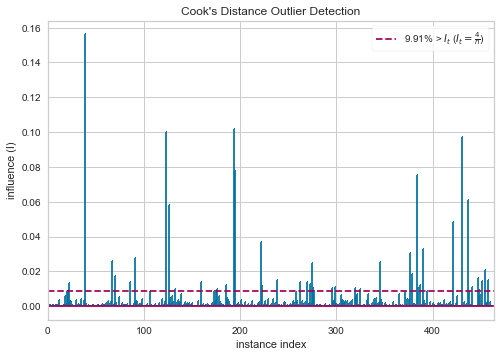

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [9]:
# let's take a look at cook's distance to explore the influence of each data point
from yellowbrick.regressor import CooksDistance

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X_train_scaled_df, y_train_df)
visualizer.show()

# TODO: deal with outliers, probably by just dropping them

### 1b. PCA

The data for PCA must be scaled first to 0 mean and unit variance. Then, we are testing which is the value of k that give us the most information.

In [10]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X_train)

# standardize the test data using the same scaling we did for the training data
X_test_sc = scaler.transform(test_means)

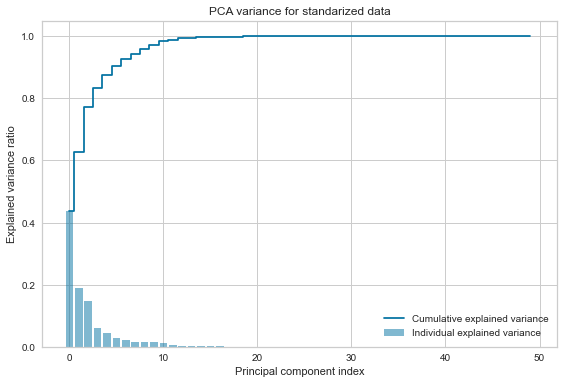

In [11]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_scaled_df)
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("PCA variance for standarized data")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [12]:
# as we can see, the first 15-18 principal components explain about 100% of the variance, 
# so moving forward let's just use the first 18 PC vectors in our models

pca = PCA(n_components=18)
X_pca = pca.fit_transform(X_train_scaled_df)
X_test_pca = pca.transform(X_test_sc)

# 2. Models

In [46]:
# Let's first create a place to store all our model evaluation results
evaluations = pd.DataFrame(index=["NB", "LogR", "LSV", "RF"])

# evals = pd.DataFrame(columns="NB", "LogR", "LSV", "RF")

accuracies = [None for i in range(4)]
pcv_no = [None for i in range(4)]
perplexities = [None for i in range(4)]
cross_valids = [None for i in range(4)]

# let's also define our performance metrics
# 1. For accuracy, we can use sklearn's built in function get_accuracy
# 2. For perplexity, we can use the following 


def perplexity_bin(X_tr, y_tr, X_te, y_te,m):
    y_pred = m.predict(X_te)
    try:
        y_probs = m.predict_proba(X_te)[:,1]
    except e:
        y_prods = prob_bin(y_pred,sum_e,sum_ne)
    return np.exp(-np.mean(np.log(y_pred*y_probs + (1 - y_pred) * (1 - y_probs))))


## 2a. Naive Bayes Model

Assumptions: Independence of variables -- which isn't true, as columns are measurements of the same variables at different distances, which are clearly not independent.

Benefits: Provides probabilities, simple to implement, interpretable 

Cons: Assumption isn't met

In [16]:
# split the scaled X_train_scaled_df and y_train_df into a training and testing set used in training 
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled_df,y_train_df, test_size=0.7, random_state=42)

In [100]:
# Create a pipeline model that
#    1. does PCA with the first i components, 
#    2.  and then creates the NB model


pipes = [Pipeline([('pca', PCA(n_components=i)),('nb',GaussianNB())]).fit(X_train,y_train) for i in range(1,30)]
y_preds = [pipe.predict(X_test) for pipe in pipes]
acc_scores = [accuracy_score(y_test,y_pred) for y_pred in y_preds]
perp_scores = [perplexity_bin(X_train, y_train, X_test, y_test, pipes[i]) for i in range(len(pipes))]

# best accuracy score, using x number of n_components
max_acc = max(acc_scores)
best_perp = min(perp_scores)

best_acc_pvc = acc_scores.index(max_acc)
best_perp_pvc = perp_scores.index(best_perp)


df = pd.DataFrame(index=['best_acc', 'best_perp', 'pca=18'])
df['accuracy'] = [max_acc, acc_scores[best_perp_pvc], acc_scores[17]]
df['perplexity'] = [perp_scores[best_acc_pvc], best_perp, perp_scores[17],]
df['no_pvc'] = [best_acc_pvc+1, best_perp_pvc+1, 18]

df

,accuracy,perplexity,no_pvc
best_acc,0.873846,1.192784,7
best_perp,0.796923,1.138567,26
pca=18,0.830769,1.146406,18


We've created 30 NB models that vary with the number of `n_components` that we give to PCA. As we saw in the data exploration phase, the first 15 or so principal component vectors explain nearly all of the data's variance. 

In using the Naive Baye's model, we can see that using PCA with the first 6 principal components actually gives us the best result, returning an accuracy score of 0.8738461538461538. 

## 2b. Logistic Regression

Assumptions: Data should be linearly separable, and there shouldn't be any influencial outliers

Benefits: highly interpretable, provides probability measures, 

Cons: Assumes linearity, sensitive to outliers

In [97]:
# let's do this similarly to the above model implementation (of NB)

pipes = [Pipeline([('pca', PCA(n_components=i)),('log',LogisticRegression())]).fit(X_train,y_train) for i in range(1,30)]
y_preds = [pipe.predict(X_test) for pipe in pipes]
acc_scores = [accuracy_score(y_test,y_pred) for y_pred in y_preds]
perp_scores = [perplexity_bin(X_train, y_train, X_test, y_test, pipes[i]) for i in range(len(pipes))]

# best accuracy score, using x number of n_components
max_acc = max(acc_scores)
best_perp = min(perp_scores)

best_acc_pvc = acc_scores.index(max_acc)
best_perp_pvc = perp_scores.index(best_perp)


df = pd.DataFrame(index=['best_acc', 'best_perp', 'pca=18'])
df['accuracy'] = [max_acc, acc_scores[best_perp_pvc], acc_scores[17]]
df['perplexity'] = [perp_scores[best_acc_pvc], best_perp, perp_scores[17],]
df['no_pvc'] = [best_acc_pvc+1, best_perp_pvc+1, 18]

df


,accuracy,perplexity,no_pvc
best_acc,0.883077,1.132040,9
best_perp,0.876923,1.121113,12
pca=18,0.876923,1.128012,18


### 2c. Linear Support Vector
Assumptions: none that affect us?

Benefits: Not sensitive to outliers unlike log regression, also linear, interpretable

Cons: None really ?

In [104]:
# same same as the other two models: let's try with varying n_components
# TODO: how to do perplexity??

pipes = [Pipeline([('pca', PCA(n_components=i)),('SVC', SVC(random_state=42))]).fit(X_train,y_train) for i in range(1,30)]
y_preds = [pipe.predict(X_test) for pipe in pipes]
acc_scores = [accuracy_score(y_test,y_pred) for y_pred in y_preds]
# perp_scores = [perplexity_bin(X_train, y_train, X_test, y_test, pipes[i]) for i in range(len(pipes))]

# best accuracy score, using x number of n_components
max_acc = max(acc_scores)
# best_perp = min(perp_scores)

best_acc_pvc = acc_scores.index(max_acc)
# best_perp_pvc = perp_scores.index(best_perp)


df = pd.DataFrame(index=['best_acc', 
#                          'best_perp', 
                         'pca=18'])
df['accuracy'] = [max_acc, acc_scores[17]]
# df['perplexity'] = [perp_scores[best_acc_pvc], best_perp, perp_scores[17],]
df['no_pvc'] = [best_acc_pvc+1, 18]

df

,accuracy,no_pvc
best_acc,0.876923,5
pca=18,0.864615,18


### 2c. Random Forest

Assumptions: TODO

Benefits: As an ensemble method, our accuracy is better because we are averaging over the decision trees correctly. For the same reason it is also not as sensitive to outliers. 

Cons: As an ensemble method, it's not _as_ interpretable_ as our other models. We also don't get probabilities with out predictions. 

#### Evaluation: 
Let's again vary the n_components given when training the random forest classification, but this time let's also vary the `max_depth` value that we pass into the random forest function between [2,7]. As we can see below, the best accuracy we get out is when our `n_components` is 4, and our `max_depth` is 6, although we get a _very_ close score of .889 when `n_components` = 17, and `max_depth` = 4. 

In [ ]:
# again, same as the other three models: let's try with varying n_components

def get_rf_prediction(rf_max_depth):
    """Returns max accuracy from training a RF model with PCA components with 1-30 components"""
    pipes = [Pipeline([('pca', PCA(n_components=i)),('RF', RandomForestClassifier(random_state=42, max_depth=rf_max_depth))]).fit(X_train,y_train) for i in range(1,30)]
    y_preds = [pipe.predict(X_test) for pipe in pipes]
    acc_scores = [accuracy_score(y_test,y_pred) for y_pred in y_preds]
    return max(acc_scores), acc_scores.index(max_acc)

for depth in range(2,8):
    print("at max depth: ", depth, ": ", get_rf_prediction(depth))

In [ ]:
accuracies[3] = 0.8953846153846153
pcv_no[3] = 4

# get perplexity 
perp = get_perplexity(y_preds[6], y_test)
perplexities[3] = perp

## 3. Evaluations

Let's look at our evaluation scores compile. 

In [ ]:
evaluations['accuracies'] = accuracies
evaluations['perplexities'] = perplexities
evaluations['cross_valids'] = cross_valids
evaluations['pcv_no'] = pcv_no


evaluations

# Multiclass test

In [ ]:
X_train = train_df[mean_cols]
y_train_mult = train_df['class4']

In [ ]:
X_train_mult,X_test_mult,y_train_mult,y_test_mult = train_test_split(X_train,y_train_mult, test_size=0.25, random_state=42,stratify=y_train_mult)

In [ ]:
y_val_b = (y_test_mult == 3).astype(int)

In [ ]:
def perplexity(p,y_test):
    return np.exp(-np.mean(np.log(y_test*p + (1 - y_test) * (1 - p))))

In [ ]:
def acc_pipe_model_mult(name,model,can_prob):
    pipe = Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=20)),(name,model)])
    pipe.fit(X_train_mult,y_train_mult)
    y_pred = pipe.predict(X_test_mult)
    perp = 1
    if can_prob:
        y_probs = pipe.predict_proba(X_test_mult)
        perp = perplexity(y_probs[:,3],y_val_b)
    acc = accuracy_score(y_test_mult,y_pred)
    return acc,perp,pipe

In [ ]:
svc = SVC(random_state=42,probability=True)
acc,perp, pipeline = acc_pipe_model_mult('svc',svc,True)
print(acc)
print(perp)

In [ ]:
cv = StratifiedKFold(n_splits=5)
cv_results = cross_validate(svc, X_train_mult, y_train_mult,cv=cv,scoring='accuracy')
cv_results

In [ ]:
cv_results.keys()

In [ ]:
log_l1 = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1', C=1.0,max_iter=2000)
acc, perp,pipeline = acc_pipe_model_mult('log_l1',log_l1,True)
print(acc)
print(perp)

In [ ]:
log_ovr = LogisticRegression(multi_class='ovr', solver='saga', penalty='l2', C=1.0,max_iter=2000)
acc,perp, pipeline_l = acc_pipe_model_mult('log_ovr',log_ovr,True)
print(acc)
print(perp)

In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state=0,max_features= 'sqrt')
acc,_, pipeline = acc_pipe_model_mult('rf',rf,False)
print(acc)

In [ ]:
list_cat

In [ ]:
#The model must be already trained and must be able to output probabilities
def generate_answers(model):
    y_pred = model.predict(X_test)
    y_pred_proba= model.predict_proba(X_test)
    df = pd.DataFrame()
    p_f = []
    lab = []
    for i,p in zip(y_pred,y_pred_proba):
        if i == 3:
            p_f.append(p[i])
            lab.append(list_cat[i])
        else:
            p_f.append(p[:3].sum())
            lab.append(list_cat[i])
    df['class4'] = lab
    df['p'] = p_f
    df.to_csv('../data/answers.csv',index=False)

#TODO Calculate perplexity  
#TODO Improve the multiclass prediction  
#TODO If we don't use a classifier that gives probabilities, we have to return the probability for each class, like the prior I think.

In [ ]:
generate_answers(pipeline_l)